<div style="color:white;
           display:fill;
           border-radius:5px;
           background-color:#5642C5;
           font-size:200%;
           font-family:Arial;letter-spacing:0.5px">

<p width = 20%, style="padding: 10px;
              color:white;">
Principal Component Analysis
              
</p>
</div>

Data Science Cohort Live NYC Feb 2022
<p>Phase 4: Topic 33</p>
<br>
<br>

<div align = "right">
<img src="Images/flatiron-school-logo.png" align = "right" width="200"/>
</div>
    
    

In [43]:
from scipy.special import gamma
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from matplotlib import pyplot as plt
import seaborn as sns
import statsmodels as sm
from statsmodels.regression.linear_model import OLS
from sklearn.metrics import mean_squared_error as mse

%matplotlib inline

#### Motivation: The curse of dimensionality

In [44]:

%%capture cod

def sphere_calc(m, R):
    numerator = (R**m * np.pi**(m/2))
    denom = gamma(m/2 + 1)
    
    return numerator/denom

dim_list = pd.Series(np.arange(1,21))
sph_vol_list = dim_list.map(lambda M: sphere_calc(M, 2)) # get +- 2 std of standardized variables

density_vs_dim = 5000/sph_vol_list
fig, ax = plt.subplots()
sns.lineplot(x = density_vs_dim.index, y = density_vs_dim.values, ax = ax)
ax.set_ylabel('Point density')
ax.set_xlabel('Number of Features')
ax.set_title('Point density:  feature dimension scaling')
plt.show()


- Need good statistical sampling in feature space for training
- Dataset becomes sparse in high dimension. Hard to do statistical learning.


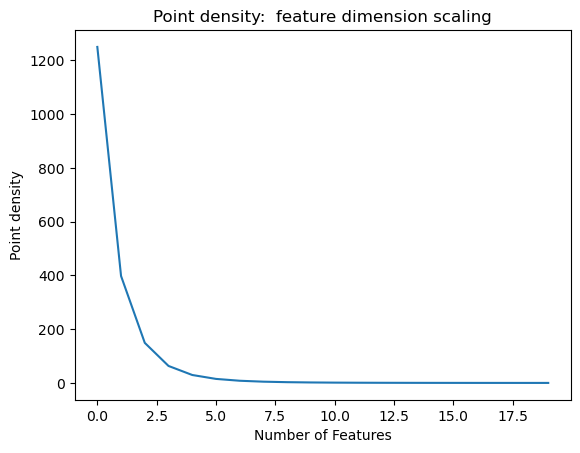

In [45]:
cod()

Small numbers (low density):

- large sample-to-sample fluctuations.

High variance from dimensionality: hard to train model that generalizes.


Another issue in data with a ton of features:
- many of the features likely correlated with each other
- high variance


Could keep all variables and regularize.
   

Or could figure out how to reduce dimension:

- construct smaller set of variables that are combinations of original variables.
- largely account for variation scale and correlations of features with this smaller set.
- i.e., reduce dim, preserve as much information as possible

#### Principal Component Analysis (PCA)

<img src = "Images/PCA_basics.gif" width = 500 />

- Transform to new coordinate system: 
    - directions characteristic of data spread in various dimensions.
    - new features uncorrelated (perpendicular)
- Find direction(s) of maximum variance:
    - project data onto this lower-D space.

Often doing this in much higher-D spaces.
- Very surprising how low the dimensionality capturing most of the feature variance can be.

Let's try an implement within given situation:

- Predict the cost to ship a package based on its features. 

In [46]:
packages = pd.read_csv('data/packages.csv')
packages.head(3)

,Shipping Cost ($),Length (in),Width (in),Height (in),Weight (lb),Distance (mi)
0,24,36,32,9,18,1079
1,38,41,31,12,18,1797
2,38,34,34,15,24,1722


In [47]:
packages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30 entries, 0 to 29
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype
---  ------             --------------  -----
 0   Shipping Cost ($)  30 non-null     int64
 1   Length (in)        30 non-null     int64
 2   Width (in)         30 non-null     int64
 3   Height (in)        30 non-null     int64
 4   Weight (lb)        30 non-null     int64
 5   Distance (mi)      30 non-null     int64
dtypes: int64(6)
memory usage: 1.5 KB


- Quite a few features for a small dataset,
- Also: likely that physical dimensions are correlated

Check out those correlations:

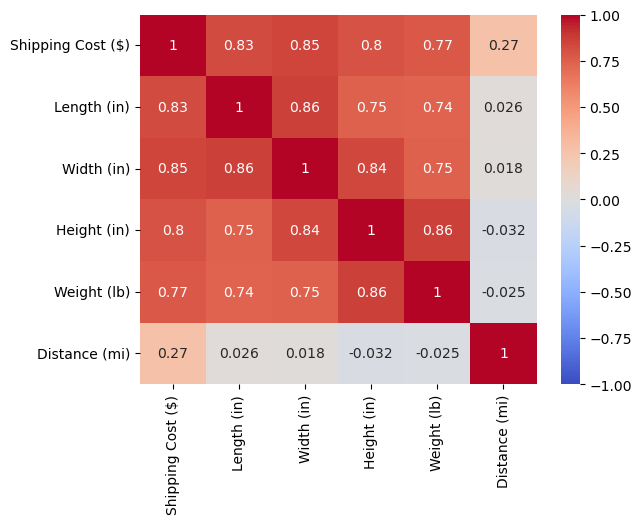

In [48]:
sns.heatmap(packages.corr(),
            annot=True,
            fmt='0.2g',
            vmin=-1,
            vmax=1,
            center=0,
            cmap='coolwarm');

Very high correlations between the different physical package characteristics.

- Some combination of variables as one variable:
- Another set for the other.

- One as strong mixture of physical features
- other dominated by Distance.
    

Visualizing: looks like a linear regression might work.
- But don't drop all features except length
- More principled way.

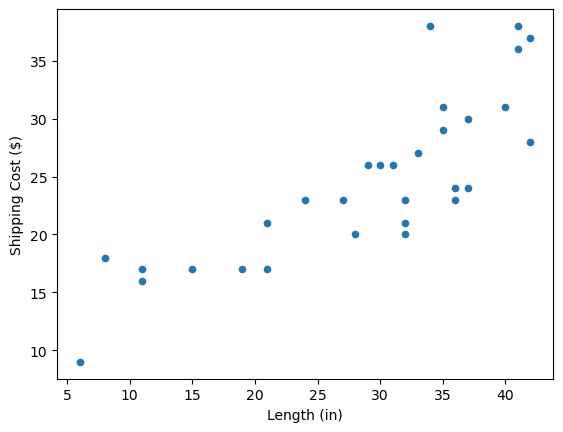

In [49]:
packages.plot(kind='scatter', y='Shipping Cost ($)', x='Length (in)');

First let's train-test split:

In [50]:
X = packages.drop(columns = ['Shipping Cost ($)'])
y = packages['Shipping Cost ($)']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25)

Now standardize our features:
- Failing to do so makes finding directions of variance:
    - dependent on scale of individual features
- Want to understand directions of high data variance unbiased by the scale of individual features.

In [51]:
scaler = StandardScaler()
X_tr_norm = scaler.fit_transform(X_train)
X_tt_norm = scaler.transform(X_test)

PCA: 
- relies on decomposing this **covariance matrix** $X^TX$ of scaled/centered data:

In [52]:
N_tr = X_tr_norm.shape[0]
Xcov = (X_tr_norm.T@X_tr_norm)/N_tr 
Xcov

array([[ 1.        ,  0.85251614,  0.72029714,  0.74900173, -0.02277729],
       [ 0.85251614,  1.        ,  0.83344692,  0.74978158, -0.05584331],
       [ 0.72029714,  0.83344692,  1.        ,  0.85443796, -0.07355873],
       [ 0.74900173,  0.74978158,  0.85443796,  1.        , -0.11088883],
       [-0.02277729, -0.05584331, -0.07355873, -0.11088883,  1.        ]])

This really nothing more than the Pearson correlation matrix

In [53]:
X_train.corr()

,Length (in),Width (in),Height (in),Weight (lb),Distance (mi)
Length (in),1.000000,0.852516,0.720297,0.749002,-0.022777
Width (in),0.852516,1.000000,0.833447,0.749782,-0.055843
Height (in),0.720297,0.833447,1.000000,0.854438,-0.073559
Weight (lb),0.749002,0.749782,0.854438,1.000000,-0.110889
Distance (mi),-0.022777,-0.055843,-0.073559,-0.110889,1.000000


In [54]:
Xcov

array([[ 1.        ,  0.85251614,  0.72029714,  0.74900173, -0.02277729],
       [ 0.85251614,  1.        ,  0.83344692,  0.74978158, -0.05584331],
       [ 0.72029714,  0.83344692,  1.        ,  0.85443796, -0.07355873],
       [ 0.74900173,  0.74978158,  0.85443796,  1.        , -0.11088883],
       [-0.02277729, -0.05584331, -0.07355873, -0.11088883,  1.        ]])

So first step of PCA

Transform coordinates: constructs new features

Linear combination of old features:

$$ \begin{bmatrix} PC_1 \\ PC_2 \end{bmatrix} = S \begin{bmatrix} X_1 \\ X_2 \end{bmatrix} = \begin{bmatrix} s_{11} & s_{12} \\ s_{21} & s_{22} \end{bmatrix}\begin{bmatrix} X_1 \\ X_2 \end{bmatrix}   $$


$$ \begin{bmatrix} PC_1 \\ PC_2 \end{bmatrix} = X_1 \begin{bmatrix} s_{11} \\ s_{12} \end{bmatrix} + X_2 \begin{bmatrix} s_{21} \\ s_{22} \end{bmatrix}   $$


$$ \begin{bmatrix} PC_1 \\ PC_2 \end{bmatrix} = X_1 \textbf{s}_1 + X_2\textbf{s}_2  $$

where $\textbf{s}_1$ and $\textbf{s}_2$ forms new coordinate system.

<img src = "Images/PCA_closeup.png" />

In transformed frame:
    
- New features not correlated.

<img src = "Images/pca_rot.jpg" width = 350 />

Task is two fold:
- find transformation that yields the principal axes of variation in data
- get variance of data in these principal directions 

**Numpy:**

Finds characteristic (eigen) directions of variance and gets (eigen) values of the variance along characteristic directions

In [55]:
from numpy import linalg
eig, eigvecs = linalg.eig(Xcov)

Covariance matrix in new coordinate system

In [56]:
colname = ['PC' + str(n) for n in range(len(Xcov)) ]
Xcov_PCA = pd.DataFrame(np.diag(eig), index = colname, columns = colname)
Xcov_PCA

,PC0,PC1,PC2,PC3,PC4
PC0,3.387634,0.00000,0.000000,0.000000,0.000000
PC1,0.000000,0.99848,0.000000,0.000000,0.000000
PC2,0.000000,0.00000,0.331203,0.000000,0.000000
PC3,0.000000,0.00000,0.000000,0.082254,0.000000
PC4,0.000000,0.00000,0.000000,0.000000,0.200429


The components of the principal directions in terms of original features:

In [57]:
pc_comp = pd.DataFrame(eigvecs.T,
                       index = colname,
                       columns = X_train.columns)
pc_comp

,Length (in),Width (in),Height (in),Weight (lb),Distance (mi)
PC0,0.489350,0.507630,0.503956,0.495823,-0.055094
PC1,0.086656,0.049302,0.009882,-0.035557,0.994333
PC2,0.625013,0.350750,-0.466778,-0.511021,-0.085495
PC3,-0.418792,0.580068,-0.570487,0.402377,0.027795
PC4,0.432435,-0.529506,-0.450104,0.574322,0.013579


PCs are mixtures of original features:
- In our case very equally distributed across different features.
- PCs are usually NOT interpretable

Looking at the variance and principal components side-by-side

In [58]:
Xcov_PCA

,PC0,PC1,PC2,PC3,PC4
PC0,3.387634,0.00000,0.000000,0.000000,0.000000
PC1,0.000000,0.99848,0.000000,0.000000,0.000000
PC2,0.000000,0.00000,0.331203,0.000000,0.000000
PC3,0.000000,0.00000,0.000000,0.082254,0.000000
PC4,0.000000,0.00000,0.000000,0.000000,0.200429


In [59]:
pc_comp

,Length (in),Width (in),Height (in),Weight (lb),Distance (mi)
PC0,0.489350,0.507630,0.503956,0.495823,-0.055094
PC1,0.086656,0.049302,0.009882,-0.035557,0.994333
PC2,0.625013,0.350750,-0.466778,-0.511021,-0.085495
PC3,-0.418792,0.580068,-0.570487,0.402377,0.027795
PC4,0.432435,-0.529506,-0.450104,0.574322,0.013579


No question that PC0 and PC1 dominate variance:

- Most dominant always called **first principal component**
- Second most dominant: **second principal component**, etc.

In [60]:
Xcov_PCA

,PC0,PC1,PC2,PC3,PC4
PC0,3.387634,0.00000,0.000000,0.000000,0.000000
PC1,0.000000,0.99848,0.000000,0.000000,0.000000
PC2,0.000000,0.00000,0.331203,0.000000,0.000000
PC3,0.000000,0.00000,0.000000,0.082254,0.000000
PC4,0.000000,0.00000,0.000000,0.000000,0.200429


In [61]:
pc_comp

,Length (in),Width (in),Height (in),Weight (lb),Distance (mi)
PC0,0.489350,0.507630,0.503956,0.495823,-0.055094
PC1,0.086656,0.049302,0.009882,-0.035557,0.994333
PC2,0.625013,0.350750,-0.466778,-0.511021,-0.085495
PC3,-0.418792,0.580068,-0.570487,0.402377,0.027795
PC4,0.432435,-0.529506,-0.450104,0.574322,0.013579


- First principal component has high weight across all features.
- Second weights distance (not physical package attribute)

Together enough to capture most variance.

#### Orthogonality: formal way of saying something we know

The directions we found are **orthogonal** or perpendicular to each other:
- Same as saying: PCs are not correlated with each other.
- In such a case: dot products between different PC vectors vanish.

$$ \textbf{u}\cdot \textbf{v} = \textbf{u}^T\textbf{v} = \begin{bmatrix} u_1 & u_2 \end{bmatrix}\begin{bmatrix} v_1 \\ v_2 \end{bmatrix}  = 0 $$

$$ \begin{bmatrix} 1 & -1 \end{bmatrix}\begin{bmatrix} 1 \\ 1 \end{bmatrix}  = 0 $$


<img src = "Images/pca_rot.jpg" width = 350 />

What we did:

<center><img src = "Images/PCA_orth.png" width = 350 /></center>

In [62]:
PC1 = eigvecs[:, 0]
PC2 = eigvecs[:, 1]
PC1.dot(PC2)

4.496182351140341e-17

#### The final step: transforming the data

We will now use these principal components to create new features. 
- These features will be weighted sums (aka **linear combinations**) of existing features
- Using the component weights from the eigenvectors.

Take first three PCs only: these **dominate** variance:
- Capture most of feature space.
- Decorrelated variables. Variance not an issue.

We will now create feature using the first 3 PCS: 

In [63]:
firstthree = pc_comp.iloc[0:3]
firstthree

,Length (in),Width (in),Height (in),Weight (lb),Distance (mi)
PC0,0.489350,0.507630,0.503956,0.495823,-0.055094
PC1,0.086656,0.049302,0.009882,-0.035557,0.994333
PC2,0.625013,0.350750,-0.466778,-0.511021,-0.085495


<img src = "Images/PCA_basics.gif" width = 500 />

Projecting the data onto these principal components

In [64]:
projected = X_tr_norm@firstthree.T

projected

,PC0,PC1,PC2
0,1.556358,0.122756,-0.187445
1,-0.882420,0.042184,1.212201
2,3.632496,-0.782514,-0.682048
3,0.111449,-0.090079,0.644375
4,-1.651599,-1.154881,-0.440422
5,-2.338089,1.355252,-0.959925
6,0.767047,-1.394921,0.348158
7,-1.397092,1.326230,0.364069
8,1.860217,1.421339,0.302138
9,1.697130,-0.836524,-0.282764


- We have lessened collinearity issue.
- Also reduced dimensionality considerably.

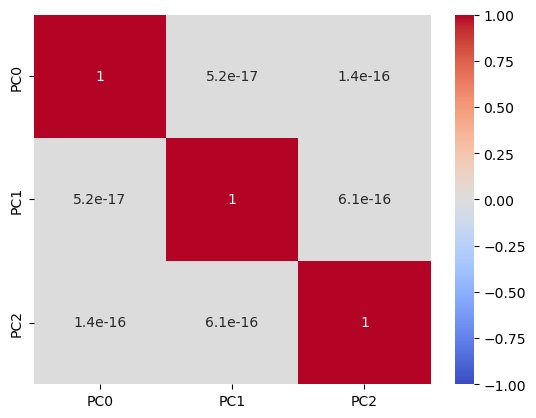

In [65]:
sns.heatmap(projected.corr(),
            annot=True,
            fmt='0.2g',
            vmin=-1,
            vmax=1,
            center=0,
            cmap= 'coolwarm');

#### Modeling

Now let's compare linear regression models with...

* All five original features 
* Only 3 best new features


**Model 1: All base features**:

In [66]:
from sklearn.linear_model import LinearRegression

In [67]:
sm1 = LinearRegression()
sm1.fit(X_tr_norm, y_train)
sm1.score(X_tr_norm, y_train)

0.8511640502587693

In [68]:
from sklearn.metrics import r2_score

In [69]:
y_test_hat = sm1.predict(X_tt_norm)
r2_score(y_test, y_test_hat)

0.7537879497362783

**Model 2: Major principal components**:

In [70]:
sm2 = LinearRegression()
sm2.fit(projected, y_train) # takes in PCA-ed + projected features

LinearRegression()

PCA transform scaled test data:
- Feed in to make prediction

In [71]:
projected_test = X_tt_norm@firstthree.T

In [72]:
y_pred = sm2.predict(projected_test) # transformed test set 

In [73]:
y_train_pred = sm2.predict(projected) #transformed train set

Evaluating training performance

In [74]:
r2_score(y_train_pred, y_train)

0.8095015497089615

In [75]:
r2_score(y_test, y_pred)

0.8361522261517234

In [76]:
y_test_hat2 = sm2.predict(X_tt_norm.dot(firstthree.T))
mse(y_test, y_test_hat2)

C:\Users\Praveen\anaconda3\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


8.558486062106073

## PCA in `sklearn`

As always, `sklearn` makes this all much easier, this time with the `PCA()` class.

In [77]:
pca = PCA(n_components=3) # Check out how `n_components` works

# fits PCA (stores eigenvalues/eigenvectors)
# applies PCA transformation/projection on scaled training data
X_tr_pca = pca.fit_transform(X_tr_norm) 

X_tr_pca

array([[ 1.5563584 , -0.12275567, -0.18744491],
       [-0.88241993, -0.04218402,  1.21220122],
       [ 3.63249633,  0.78251432, -0.68204828],
       [ 0.11144878,  0.09007855,  0.64437512],
       [-1.65159855,  1.15488106, -0.4404218 ],
       [-2.33808888, -1.35525186, -0.95992471],
       [ 0.76704691,  1.39492096,  0.34815798],
       [-1.39709226, -1.32623019,  0.36406876],
       [ 1.86021668, -1.42133937,  0.30213798],
       [ 1.69713042,  0.83652407, -0.28276423],
       [-1.79663416,  1.24035625, -0.95342419],
       [-0.03938674,  0.89742168,  0.72625392],
       [ 2.99384833, -0.38765462, -0.65417834],
       [ 0.79389817, -0.43051932,  0.24908107],
       [ 1.42590719, -0.17716694,  0.45296816],
       [-3.18596116,  1.74450691, -0.30466998],
       [ 1.69194752, -0.54740657, -0.11647844],
       [-2.45790236, -0.5834704 , -0.01779986],
       [ 0.52266265,  1.37843632,  0.54431777],
       [-0.50463917, -1.11657639,  0.26596759],
       [-2.55896763, -0.70886275,  0.304

Saved parameters:
- **Get eigenvectors determined from covariance matrix of training data**
- Get eigenvalues: variance of data in different principal directions

In [78]:
pca.components_

array([[ 0.48934998,  0.5076303 ,  0.50395629,  0.49582329, -0.05509449],
       [-0.08665555, -0.0493015 , -0.00988246,  0.03555679, -0.99433306],
       [ 0.62501306,  0.35074977, -0.46677781, -0.51102086, -0.08549519]])

- These are components of PC vectors in original feature space.
- Sometimes the signs get flipped on the eigenvectors - don't worry about it. Think of "up" and "down" as both representing the same dimension, just in opposite directions.

Saved parameters:
- Get eigenvectors determine from covariance matrix of training data
- **Get eigenvalues of covariance matrix of training data:**
   - **variance of data in different principal directions**

In [79]:
pca.explained_variance_

array([3.54895   , 1.04602704, 0.34697426])

Often useful to see percentage of total variance explained by each PC:
- percentage of eigenvalue (i.e., variance) of given PC
- with respect to total variance of the data 

In [80]:
pca.explained_variance_ratio_

array([0.67752682, 0.19969607, 0.06624054])

After PCA, you can use your transformed data as you would in any model:
- PCA acts as a transformer in the pipeline 

In [81]:
from sklearn.pipeline import Pipeline

steps = [('scaler', StandardScaler()), ('pca', PCA(n_components = 3)), ('model', LinearRegression())  ]
mod_pipe = Pipeline(steps)

Fitting the model on unscaled data:
- fits/transforms scaler
- PCA and transform scalef train set
- PCA-ed features sent to model 

In [82]:
mod_pipe.fit(X_train,y_train) 

Pipeline(steps=[('scaler', StandardScaler()), ('pca', PCA(n_components=3)),
                ('model', LinearRegression())])

Now evaluate:
- train set performance
- test set generalization

In [83]:
mod_pipe.score(X_train,y_train) 

0.8399842937683222

In [84]:
mod_pipe.score(X_test,y_test) 

0.8361522261517232

May need to tune n_components using grid-searching:
- but EDA can usually help a lot with this
- get eigenvalues of scaled/centered variance matrix and determine how many principal components are significant.